In [1]:
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import datetime

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [3]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"

In [4]:
CICE5_PATH = '/scratch/tm70/sw6175/access-esm/archive/esm1.6-preind-apr+cice5-continue-80-202504-dev-preindustrial+concentrations+cice5-6a4744ed'
CICE4_PATH = '/scratch/p66/jxs599/access-esm/archive/AprilSpinUp-AprilSpinUp-56aae814'
ONEAPI_PATH = '/g/data/tm70/as2285/payu/esm1.6-preind-202504-cice5-oneapi/archive/'

# Load the observational dataset

The CDR dataset has the area of each grid cell provided as a seperate file, which we need to load

In [5]:
def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds = ds.cdr_conc
    ds = ds.where(ds<=1)  # convert error codes to Nan

    return ds

We can pull the datasets direct from the url, however the cell area needs to be downloaded seperately:

In [6]:
!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


We are interested in the Antarctic, but the lines for the Arctic are below and commented out.

In [7]:
sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat").sel(time=slice("1981","2010"))

nh_cdr_xr = open_cdr_dataset(
    nh_obs_url,
    'psn25area_v3.dat'
).sel(time=slice("1981","2010"))


# And our data

In [8]:
from dask.distributed import Client

In [9]:
client = Client(threads_per_worker = 1)

2025-06-24 12:04:34,622 - distributed.nanny - WARNING - Restarting worker
2025-06-24 12:04:35,228 - distributed.nanny - WARNING - Restarting worker
2025-06-24 12:04:35,611 - distributed.nanny - WARNING - Restarting worker
2025-06-24 12:07:02,568 - distributed.nanny - WARNING - Restarting worker
2025-06-24 14:21:28,420 - distributed.nanny - WARNING - Restarting worker
2025-06-24 14:22:24,946 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:42831' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-temp_surface_ave-52c299081b6ac8777155fc8728386165', 'original-open_dataset-temp_surface_ave-43d3ad0534d810311ead4c2d781723d7'} (stimulus_id='handle-worker-cleanup-1750738944.9456284')
2025-06-24 14:22:24,957 - distributed.nanny - WARNING - Restarting worker
2025-06-24 14:23:29,098 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:43047' caused the cluster to lose already computed task(s), which 

In [10]:
client

<Client: 'tcp://127.0.0.1:41569' processes=12 threads=12, memory=46.00 GiB>

In [11]:
def _preproc(ds):
    return ds[['aice','hi', 'tarea']]

In [12]:
ds_cice4 = xr.open_mfdataset(f'{CICE4_PATH}/output[6-7][0-9][0-9]/ice/HISTORY/iceh.*', compat='override', coords='minimal', parallel=True, preprocess = _preproc)

[gadi-cpu-clx-2719:2439340:0:2439340] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x48)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
double free or corruption (!prev)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf E

In [13]:
ds_intel = xr.open_mfdataset(f'{CICE5_PATH}/output*/ice/HISTORY/iceh.0[6-9][0-9][0-9]-[0-9][0-9].nc',
                              compat='override', data_vars='minimal',
                    coords='minimal', parallel=True,
                             preprocess = _preproc
                             )





/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [14]:
ds_intel

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 1200, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 10kB 0786-01-16 12:00:00 ... 0885-12-16 12:00:00
    TLON     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULON     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    ULAT     (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables:
    aice     (time, nj, ni) float32 518MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi       (time, nj, ni) float32 518MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea    (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This year has 365 days
    comment2:     File written on model date 07860201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-06-12 at 22:55:58.0
    io_flavor:    io_netcdf

In [15]:
ds_oneapi = xr.open_mfdataset(f'{ONEAPI_PATH}/output*/ice/HISTORY/iceh.0[6-9][0-9][0-9]-[0-9][0-9].nc',
                              compat='override', data_vars='minimal',
                    coords='minimal', parallel=True,
                             preprocess = _preproc
                             )





/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [16]:
CLIMAT_SLICE=slice("0786","0816")

Text(0.5, 1.0, 'SH Ice Area')

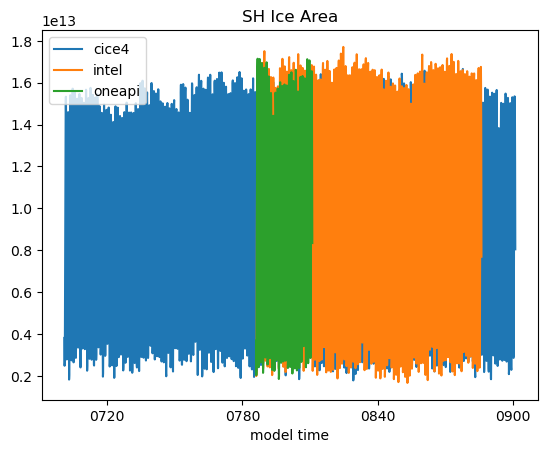

In [17]:
for ids in [ds_cice4, ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(0,150)).sum(['ni','nj']).plot()

plt.legend(labels=['cice4', 'intel','oneapi'])
plt.title('SH Ice Area')

Text(0.5, 1.0, 'SH Ice Area')

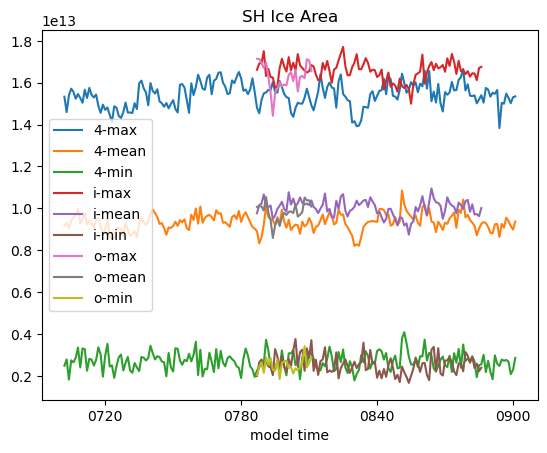

In [18]:
for ids in [ds_cice4,ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).max().plot()
    (tarea*ids.aice).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).mean().plot()
    (tarea*ids.aice).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).min().plot()


plt.legend(labels=['4-max','4-mean','4-min','i-max','i-mean','i-min','o-max','o-mean','o-min'])
plt.title('SH Ice Area')

Text(0.5, 1.0, 'SH Ice Vol')

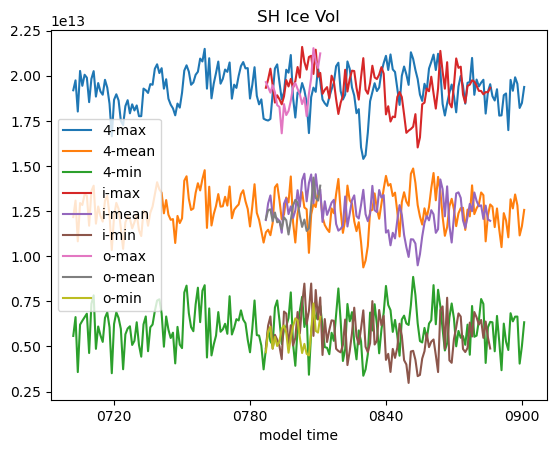

In [19]:
for ids in [ds_cice4,ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.hi.load()
    (tarea*ids.hi).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).max().plot()
    (tarea*ids.hi).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).mean().plot()
    (tarea*ids.hi).sel(nj=slice(0,150)).sum(['ni','nj']).resample({'time':'YE'}).min().plot()


plt.legend(labels=['4-max','4-mean','4-min','i-max','i-mean','i-min','o-max','o-mean','o-min'])
plt.title('SH Ice Vol')

Text(0.5, 1.0, 'NH Ice Area')

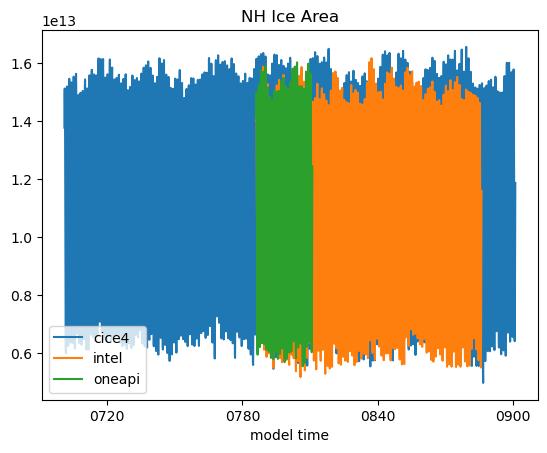

In [20]:
for ids in [ds_cice4, ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(150,None)).sum(['ni','nj']).plot()

plt.legend(labels=['cice4', 'intel','oneapi'])
plt.title('NH Ice Area')

Text(0.5, 1.0, 'NH Ice Area')

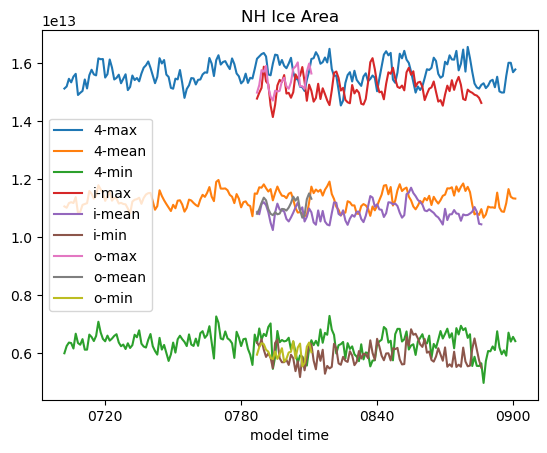

In [21]:
for ids in [ds_cice4, ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.aice).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).max().plot()
    (tarea*ids.aice).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).mean().plot()
    (tarea*ids.aice).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).min().plot()


plt.legend(labels=['4-max','4-mean','4-min','i-max','i-mean','i-min','o-max','o-mean','o-min'])
plt.title('NH Ice Area')

Text(0.5, 1.0, 'NH Ice Vol')

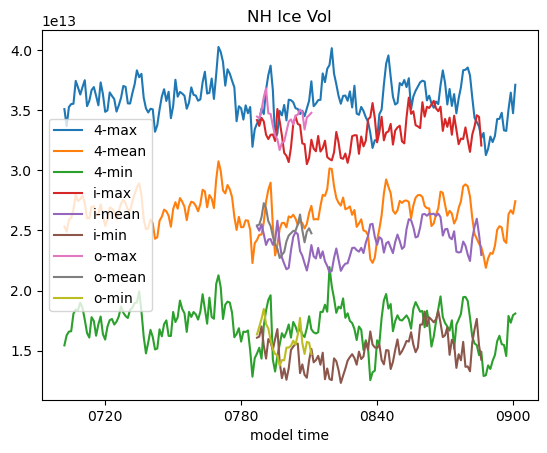

In [22]:
for ids in [ds_cice4, ds_intel, ds_oneapi] : 
    tarea = ids.tarea.load()
    ids.aice.load()
    (tarea*ids.hi).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).max().plot()
    (tarea*ids.hi).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).mean().plot()
    (tarea*ids.hi).sel(nj=slice(150,None)).sum(['ni','nj']).resample({'time':'YE'}).min().plot()


plt.legend(labels=['4-max','4-mean','4-min','i-max','i-mean','i-min','o-max','o-mean','o-min'])
plt.title('NH Ice Vol')

In [23]:
sh = {'slice':slice(0,150), 'name':'SH', 'obs':sh_cdr_xr}
nh = {'slice':slice(150,None), 'name':'NH', 'obs':nh_cdr_xr}

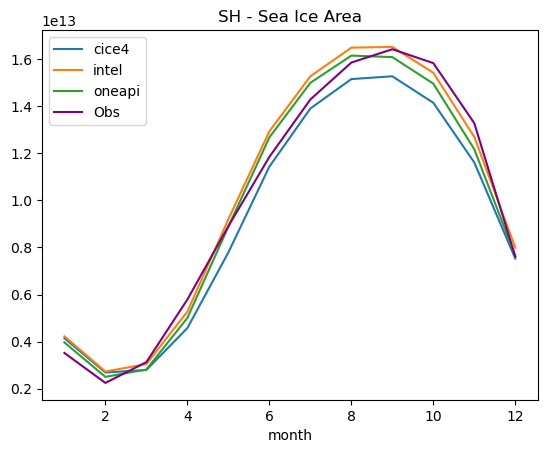

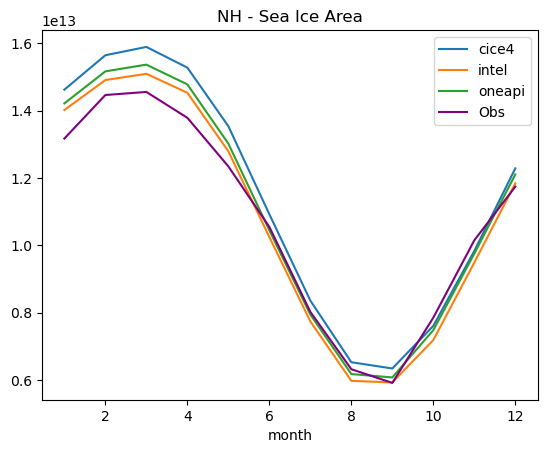

In [24]:
for iHem in [sh,nh]:
    # for ids in [ds_cice5]:
    #     tarea = ids.tarea.load()
    #     ids.aice.load()
    #     (tarea*ids.aice).sel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
    
    # plt.legend(labels=['c5'])
    
    # plt.twiny()
    
    for ids in [ds_cice4, ds_intel, ds_oneapi]:
        tarea = ids.tarea.load()
        ids.aice.load()
        (tarea*ids.aice).sel(time=CLIMAT_SLICE).isel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
    
    (iHem['obs']*iHem['obs'].area*1e6).sum(['x','y']).groupby('time.month').mean().plot(c='purple')
    
    plt.title(iHem['name'] + ' - Sea Ice Area')
    plt.legend(labels=['cice4', 'intel','oneapi', 'Obs'])
    plt.show()

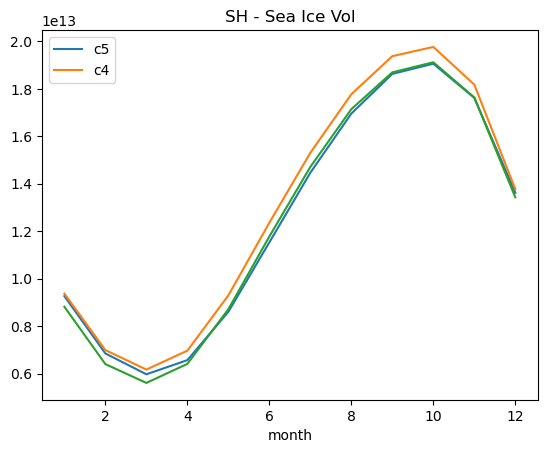

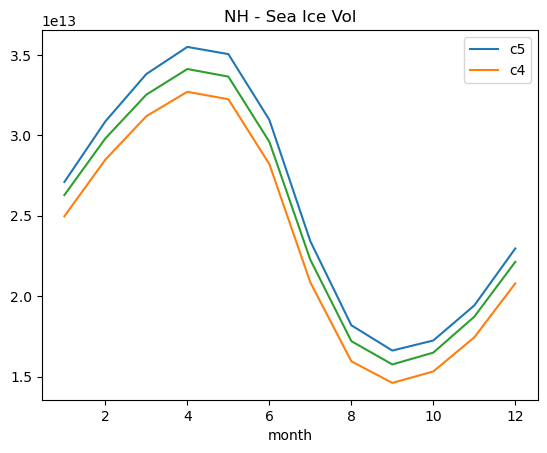

In [25]:
for iHem in [sh,nh]:
    # for ids in [ds_noneic]:
    #     tarea = ids.tarea.load()
    #     ids.hi.load()
    #     (tarea*ids.hi).sel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
    
    # plt.legend(labels=['c5+noneic'])
    
    # plt.twiny()
    
    for ids in [ds_cice4, ds_intel, ds_oneapi]:
        tarea = ids.tarea.load()
        ids.hi.load()
        (tarea*ids.hi).sel(time=CLIMAT_SLICE).isel(nj=iHem['slice']).sum(['ni','nj']).groupby('time.month').mean().plot()
        
    plt.title(iHem['name'] + ' - Sea Ice Vol')
    plt.legend(labels=['c5', 'c4'])
    plt.show()

In [33]:
i_ocn_scalar_ds = xr.open_mfdataset(
    f'{CICE5_PATH}/output0*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [34]:
o_ocn_scalar_ds = xr.open_mfdataset(
    f'{ONEAPI_PATH}/output0*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [35]:
c4_scalar_ds = xr.open_mfdataset(
    f'{CICE4_PATH}/output[5-9]*/ocean/ocean-scalar-1monthly-ym_0*.nc'
)


/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/coding/times.py:1001: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data

In [29]:
list(i_ocn_scalar_ds.data_vars)[0:-4]

['total_mass_seawater',
 'total_volume_seawater',
 'eta_global',
 'eta_adjust',
 'pbot_adjust',
 'temp_global_ave',
 'salt_global_ave',
 'no3_global_ave',
 'fe_global_ave',
 'o2_global_ave',
 'dic_global_ave',
 'alk_global_ave',
 'dicr_global_ave',
 'dicp_global_ave',
 'caco3_global_ave',
 'det_global_ave',
 'phy_global_ave',
 'pchl_global_ave',
 'zoo_global_ave',
 'total_ocean_pme_river',
 'total_ocean_river',
 'total_ocean_evap',
 'total_ocean_pme_sbc',
 'total_ocean_fprec',
 'total_ocean_lprec',
 'total_ocean_runoff',
 'total_ocean_salt',
 'total_ocean_heat',
 'total_ocean_hflux_pme',
 'total_ocean_swflx',
 'total_ocean_swflx_vis',
 'total_ocean_evap_heat',
 'total_ocean_lw_heat',
 'total_ocean_sens_heat',
 'total_ocean_fprec_melt_heat',
 'total_ocean_runoff_heat',
 'ke_tot',
 'pe_tot',
 'temp_surface_ave',
 'salt_surface_ave',
 'no3_surface_ave',
 'fe_surface_ave',
 'o2_surface_ave',
 'dic_surface_ave',
 'alk_surface_ave',
 'dicr_surface_ave',
 'dicp_surface_ave',
 'caco3_surface_a

Exception ignored in: <function CachingFileManager.__del__ at 0x146d6002ab60>
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 250, in __del__
    self.close(needs_lock=False)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 234, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2618, in netCDF4._netCDF4.Dataset.close
[gadi-cpu-clx-2719:2439472:0:2439513] Caught signal 11 (Segmentation fault: invalid permissions for mapped object at address 0x146d6021dff0)
  File "src/netCDF4/_netCDF4.pyx", line 2585, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2113, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: NetCDF: HDF error
2025-06-24 14:23:29,335 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-4f43ab54db0abb481dc

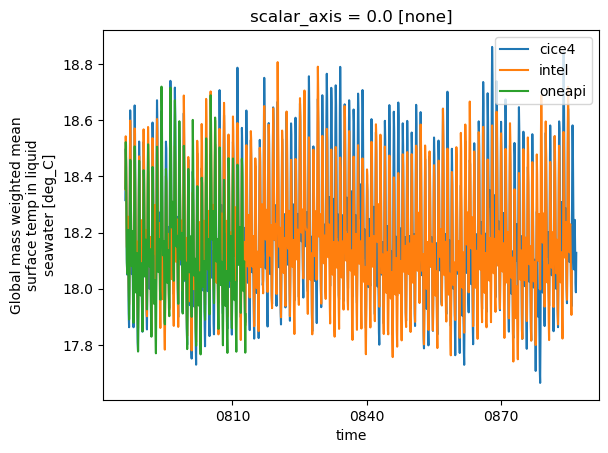

In [36]:
iVar = 'temp_surface_ave'
c4_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
i_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
o_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
plt.legend(labels=['cice4', 'intel','oneapi'])
plt.show()

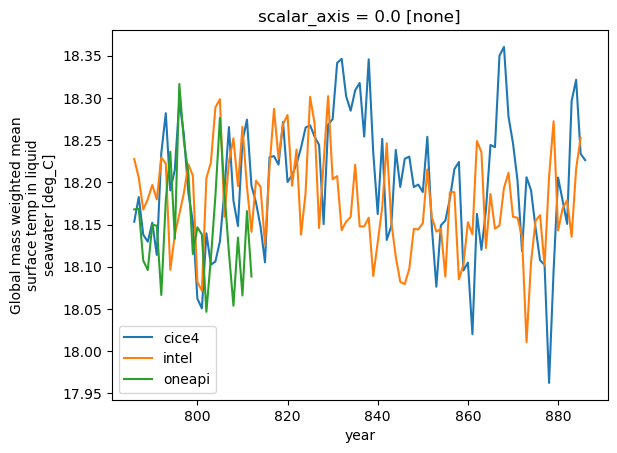

In [37]:
iVar = 'temp_surface_ave'
c4_scalar_ds[iVar].sel(time=slice("0786","0886")).load().groupby('time.year').mean().plot()
i_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().groupby('time.year').mean().plot()
o_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().groupby('time.year').mean().plot()
plt.legend(labels=['cice4', 'intel','oneapi'])
plt.show()

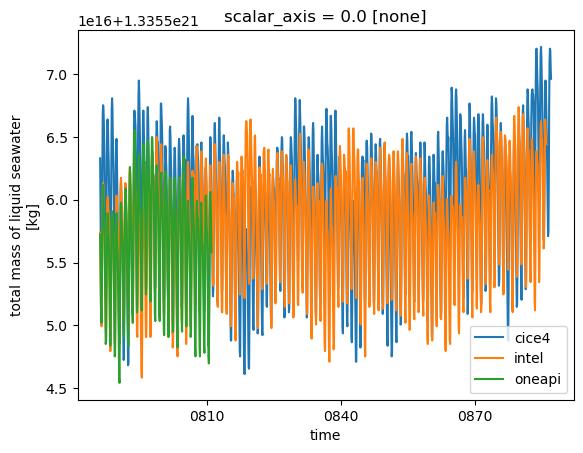

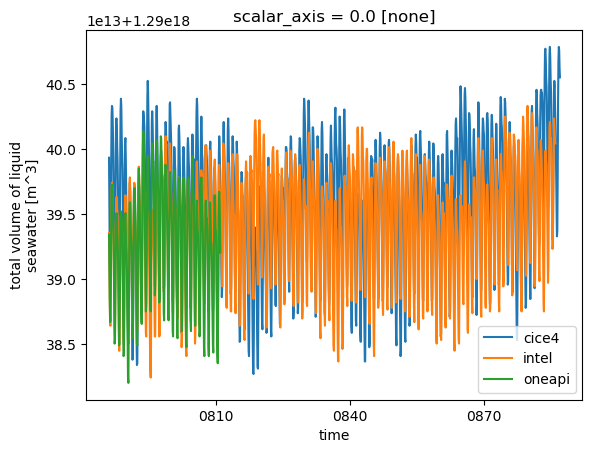

[gadi-cpu-clx-2719:2439314:0:2439314] Caught signal 11 (Segmentation fault: address not mapped to object at address 0xffffffff)
[gadi-cpu-clx-2719:2439314:1:2439458] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x60)


[1750738887.458855] [gadi-cpu-clx-2719:2439314:1]           debug.c:1290 UCX  WARN  ucs_debug_disable_signal: signal 8 was not set in ucs


BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf E

RuntimeError: NetCDF: Can't open HDF5 attribute

BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf E

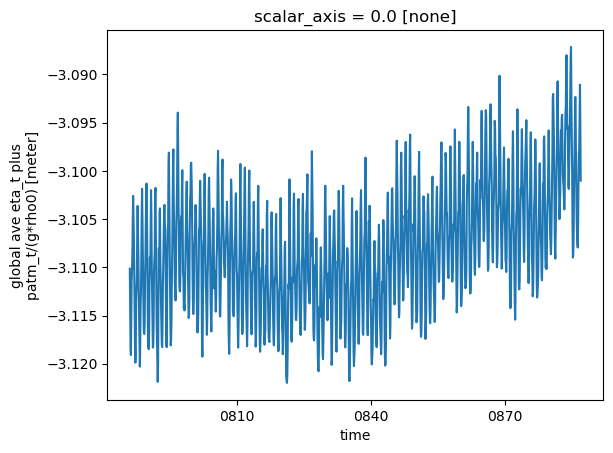

In [31]:
for iVar in list(i_ocn_scalar_ds.data_vars)[0:-4]:
    c4_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
    i_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
    o_ocn_scalar_ds[iVar].sel(time=slice("0786","0886")).load().plot()
    plt.legend(labels=['cice4', 'intel','oneapi'])
    plt.show()